In [ ]:
pip install pycountry_convert

# Executive Summary

According to the Cambridge Dictionary [1] "having your head in the clouds" means to not know the facts of a situation.
Let's get our heads out of the clouds by learning some facts about the current situation of cloud computing with the help of the 2021 Kaggle survey data.

**Key Findings:**
- Due to the COVID-19 pandemic an **accelerated increase in the usage of cloud computing platforms among Kagglers** can be seen compared to previous years
- The usage of cloud computing platforms is not only cost-effective but can also **increase the productiveness of an organization's data science team**: Data scientists who use cloud computing platforms on a regular basis have three main activities on average, which is one more than data scientists who don't use cloud computing platforms on a regular basis.
- Having skills in cloud computing pays off: On average across all countries, Kagglers using cloud computing platforms on a regular basis **earn 1.7 times** more than those who don't
- The cloud computing market is fragmented across the globe:
    - Globally, the **three most popular** cloud computing platforms are **AWS, GCP, and Azure**. However, **Alibaba Cloud and Tencent Cloud dominate the Chinese market**
    - The cloud adoption is comparatively **low in Europe and Africa**
- For the 2022 Kaggle survey it would be interesting to **include GAIA-X as an answer option for cloud computing platforms** to see how it will develop
- The level of adoption to cloud computing of an organization was found to be related to the following factors:
    - increases with increasing **organization size**
    - depends on whether the organization's **industry is highly regulated** or not
- In a highly competitive market, we have seen **different growth strategies** among the big three:
    - While AWS seems to see growth potential in highly regulated industries, GCP seems to target future generations of cloud computing users in academia.

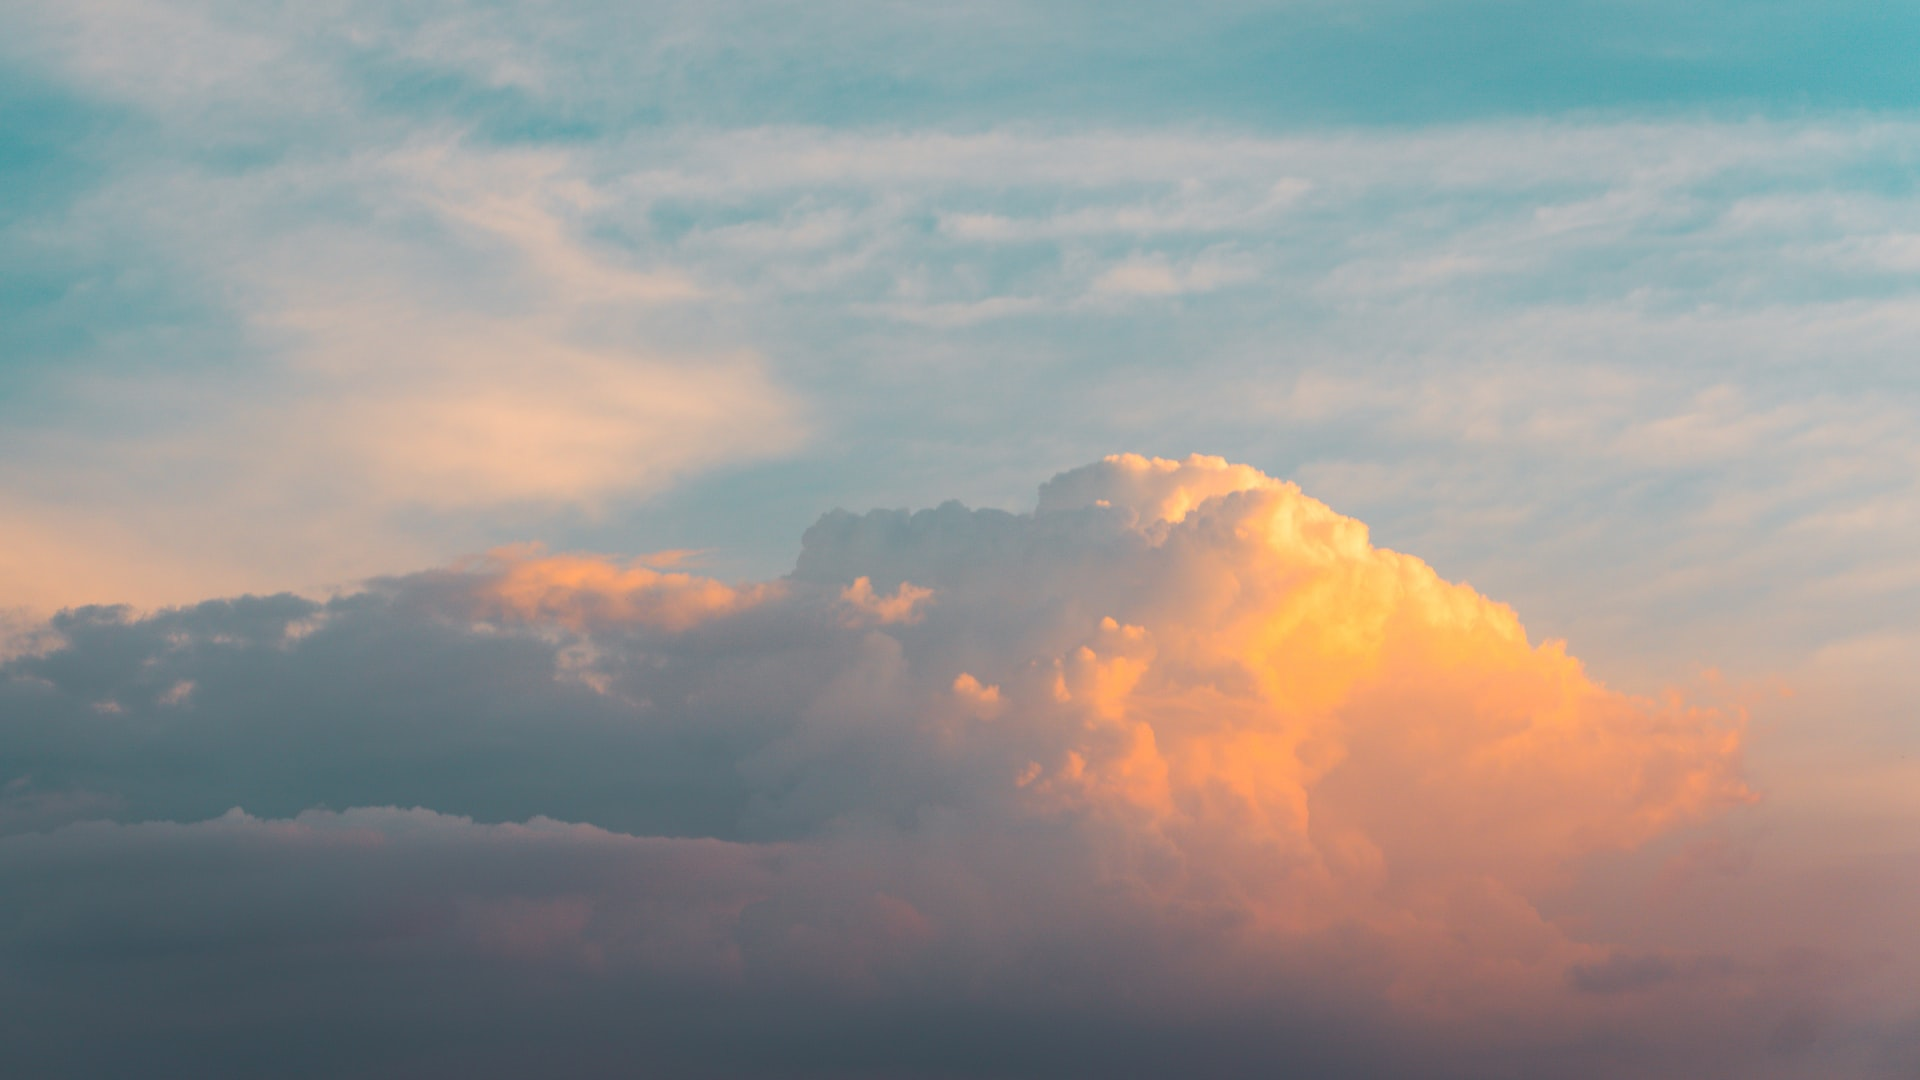

Photo by <a href="https://unsplash.com/@yeahatnet?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Peiheng Yang</a> on <a href="https://unsplash.com/?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

# Data Overview

For the following analysis, **we will mainly consider "professionals", meaning that we exclude students and currently unemployed**. The reason for this is that we want to evaluate the current cloud computing landscape in the industry. Also, Kaggle has used an alternate set of questions for students regarding cloud computing, which we can later use to evaluate future trends:

> For questions about cloud computing products, students and respondents that have never spent money in the cloud were given an alternate set of questions that asked them "what products they would like to become familiar with" instead of asking them "which products they use most often". [...] - see [kaggle_survey_2021_methodology.pdf](https://www.kaggle.com/c/kaggle-survey-2021/data)

This reduces the amount of considered respondents from about 25,973 to 17,183.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option("display.max_columns", None)
from math import pi
from scipy.interpolate import interp1d

import pycountry_convert as pc # Get continent from country name

import warnings # Supress warnings
warnings.filterwarnings("ignore")

### Visualizations ###
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 14})

from matplotlib_venn import venn3, venn3_circles

# seaborn
import seaborn as sns

# plotly
import plotly.graph_objects as go
import plotly.express as px

# Word Cloud
import re
import string
import spacy # Leading library for NLP
nlp = spacy.load('en_core_web_sm')

from wordcloud import WordCloud

# Load 2021 Kaggle survey
responses = pd.read_csv("../input/kaggle-survey-2021/kaggle_survey_2021_responses.csv", low_memory = False)

# Remove first row
responses = responses[1:].reset_index(drop=True)

# Set Color Palettes for the notebook
main_color = "#87bec7"
contrast_color = "#516A71"
contrast_color2 = "#9BA9AC"
highlight_color = "#E79972"
highlight_color2 = "#FDCC75"

custom_palette = ["#516A71","#5FA8B4","#9BA9AC","#E79972","#FDCC75"]

custom_cmap = LinearSegmentedColormap.from_list("", ['white', main_color,  contrast_color])
plt.cm.register_cmap("custom_cmap", custom_cmap)

def get_custom_palette(n_colors):
    return sns.color_palette("custom_cmap", n_colors=n_colors)



##### Q3 #####
cloud_df = responses[['Q3']].copy()
cloud_df.columns = ['Country']

country_dict = {'Iran, Islamic Republic of...' : 'Iran', 
                'Other' : 'Kazakhstan',  # Dummy, will be replaced in later step
                'I do not wish to disclose my location' : 'Kazakhstan', # Dummy, will be replaced in later step
               'Hong Kong (S.A.R.)' : 'Hong Kong'}
cloud_df['Country_code'] = cloud_df['Country'].replace(country_dict).apply(lambda x: pc.country_name_to_country_alpha2(x, cn_name_format="default"))
cloud_df['Continent'] = cloud_df['Country_code'].apply(lambda x: pc.country_alpha2_to_continent_code(x))
cloud_df['Continent']= np.where(((cloud_df.Country == 'Other') | (cloud_df.Country == 'I do not wish to disclose my location')), np.nan, cloud_df['Continent'])

##### Q5 #####
cloud_df['Role']  = responses['Q5']

##### Q10 #####
cloud_df['Hosted Notebook Products Usage'] = responses[(responses.columns[responses.columns.str.startswith('Q10') & (responses.columns != 'Q10_Part_16')])].any(axis=1)

##### Q11 #####
cloud_df['Computing Platform']  = responses['Q11']

##### Q15 #####
cloud_df['ML_experience'] = responses['Q15']

##### Q20 #####
cloud_df['Industry']  = responses['Q20']

##### Q21 #####
cloud_df['Company Size']  = responses['Q21']

##### Q24 #####
temp = responses[(responses.columns[responses.columns.str.startswith('Q24')])]
temp.columns = [f'Activity: {temp[temp[c].notna()][c].unique()[0].strip()}' for c in temp.columns]
cloud_df = pd.concat([cloud_df, temp.notna()], axis=1)

salary_dict = {'$0-999' : 500,
               '1,000-1,999' : 1500,
               '2,000-2,999' : 2500,
               '3,000-3,999' : 3500, 
               '4,000-4,999' : 4500, 
               '5,000-7,499' : 6250,
               '7,500-9,999' : 8750,
               '10,000-14,999' : 12500,
               '15,000-19,999' : 17500,
               '20,000-24,999' : 22500,
               '25,000-29,999' : 27500,
               '30,000-39,999' : 35000,
               '40,000-49,999' : 45000,
               '50,000-59,999' : 55000,
               '60,000-69,999' : 65000, 
               '70,000-79,999' : 75000,
               '80,000-89,999' : 85000,
               '90,000-99,999' : 95000,
               '100,000-124,999' : 112500, 
               '125,000-149,999' : 137500,
               '150,000-199,999' : 175000,
               '200,000-249,999' : 225000,
               '250,000-299,999' : 275000,
               '300,000-499,999' : 400000,
               '$500,000-999,999' : 750000, 
               '>$1,000,000' : 1000000,
       }

##### Q25 #####
cloud_df['Salary']  = responses['Q25'].replace(salary_dict)

##### Q27 #####
temp = responses[(responses.columns[responses.columns.str.startswith('Q27_A')])]
temp.columns = [f'Platform: {temp[temp[c].notna()][c].unique()[0].strip()}' for c in temp.columns]
cloud_df = pd.concat([cloud_df, temp.notna()], axis=1)

cloud_df['cloud_usage'] = responses[(responses.columns[responses.columns.str.startswith('Q27_A') & (responses.columns != 'Q27_A_Part_11')])].any(axis=1)

temp = responses[(responses.columns[responses.columns.str.startswith('Q27_B')])]
temp.columns = [f'Platform 2y: {temp[temp[c].notna()][c].unique()[0].strip()}' for c in temp.columns]
cloud_df = pd.concat([cloud_df, temp.notna()], axis=1)

cloud_df['num_platforms'] = cloud_df[cloud_df.columns[cloud_df.columns.str.startswith('Platform: ') & ~cloud_df.columns.str.contains('Platform: None')]].sum(axis=1)#.value_counts().to_frame().reset_index(drop=False)

##### Q28 #####
cloud_df['Experience']  = responses['Q28']
cloud_df = pd.concat([cloud_df, pd.get_dummies(responses[['Q28']], prefix='Experience')], axis=1)

##### Q29 #####
temp = responses[(responses.columns[responses.columns.str.startswith('Q29_A')])]
temp.columns = [f'Products: {temp[temp[c].notna()][c].unique()[0].strip()}' for c in temp.columns]
cloud_df = pd.concat([cloud_df, temp.notna()], axis=1)

cloud_df['Cloud Computing Products Usage'] = responses[(responses.columns[responses.columns.str.startswith('Q29_A') & (responses.columns != 'Q29_A_Part_4')])].any(axis=1)

##### Q30 #####
temp = responses[(responses.columns[responses.columns.str.startswith('Q30_A')])]
temp.columns = [f'Data Storage Products: {temp[temp[c].notna()][c].unique()[0].strip()}' for c in temp.columns]
data_storage_cols = temp.columns
cloud_df = pd.concat([cloud_df, temp.notna()], axis=1)

cloud_df['Data Storage Products Usage'] = responses[(responses.columns[responses.columns.str.startswith('Q30_A') & (responses.columns != 'Q30_A_Part_7')])].any(axis=1)

def custom_func(x, data_storage_products):
    if x.sum(axis=0) == 0:
        return 'None'
    elif x['Data Storage Products: No / None']:
        return 'None'
    elif (x.sum(axis=0) == 1) & x[f'Data Storage Products: {data_storage_products[0]}']:
        return data_storage_products[0]
    elif (x.sum(axis=0) == 1) & x[f'Data Storage Products: {data_storage_products[1]}']:
        return data_storage_products[1]
    elif (x.sum(axis=0) == 2) & x[f'Data Storage Products: {data_storage_products[0]}'] & x[f'Data Storage Products: {data_storage_products[1]}']:
        return 'Both'
    elif (x.sum(axis=0) > 1) & (x[f'Data Storage Products: {data_storage_products[0]}'] | x[f'Data Storage Products: {data_storage_products[1]}']):
        return 'Mixed with other'
    elif ~x[f'Data Storage Products: {data_storage_products[0]}'] & ~x[f'Data Storage Products: {data_storage_products[1]}']:
        return 'Other'
    else:
        return 'Something went wrong'


cloud_df['Amazon Data Storage Products'] = cloud_df[data_storage_cols].apply(lambda x: custom_func(x, 
                                                                        ['Amazon Simple Storage Service (S3)',
                                                                         'Amazon Elastic File System (EFS)']), axis=1)

cloud_df['Microsoft Data Storage Products'] = cloud_df[data_storage_cols].apply(lambda x: custom_func(x, 
                                                                        ['Microsoft Azure Data Lake Storage',
                                                                         'Microsoft Azure Disk Storage']), axis=1)

cloud_df['Google Data Storage Products'] = cloud_df[data_storage_cols].apply(lambda x: custom_func(x, 
                                                                        ['Google Cloud Storage (GCS)',
                                                                         'Google Cloud Filestore']), axis=1)



##### Q31 #####
temp = responses[(responses.columns[responses.columns.str.startswith('Q31_A')])]
temp.columns = [f'Managed ML Products: {temp[temp[c].notna()][c].unique()[0].strip()}' for c in temp.columns]
cloud_df = pd.concat([cloud_df, temp.notna()], axis=1)

cloud_df['Managed ML Products Usage'] = responses[(responses.columns[responses.columns.str.startswith('Q31_A') & (responses.columns != 'Q31_A_Part_9')])].any(axis=1)

##### Q32 #####
temp = responses[(responses.columns[responses.columns.str.startswith('Q32_A')])]
temp.columns = [f'Big Data Products: {temp[temp[c].notna()][c].unique()[0].strip()}' for c in temp.columns]
cloud_df = pd.concat([cloud_df, temp.notna()], axis=1)

cloud_df['Big Data Products Usage'] = responses[(responses.columns[responses.columns.str.startswith('Q32_A') & (responses.columns != 'Q32_A_Part_20')])].any(axis=1)

##### Q37 #####
temp = responses[(responses.columns[responses.columns.str.startswith('Q37_A')])]
temp.columns = [f'Automated ML: {temp[temp[c].notna()][c].unique()[0].strip()}' for c in temp.columns]
cloud_df = pd.concat([cloud_df, temp.notna()], axis=1)

cloud_df['Automated ML Usage'] = responses[(responses.columns[responses.columns.str.startswith('Q37_A') & (responses.columns != 'Q37_A_Part_7')])].any(axis=1)

##### Q40 #####
cloud_df['Cloud-certification programs (direct from AWS, Azure, GCP, or similar)']  = responses['Q40_Part_9'].notna()

#####################################################
cloud_students_df = cloud_df[(cloud_df.Role == 'Student')].copy()

cloud_df = cloud_df[(cloud_df.Role != 'Currently not employed') & (cloud_df.Role != 'Student')]


# Code edited from https://www.kaggle.com/kayvanshah/insights-into-kaggle-survey-2021
fig = go.Figure()

fig.add_trace(
    go.Indicator(
        mode = "number",
        value = cloud_df.shape[0],
        title = {"text": f"Number of Professionals on Kaggle <br> out of {responses.shape[0]:,} Respondents"},
        domain = {'x': [0, 0.5], 'y': [0, 1]},
    )
)

fig.update_layout(font_color = main_color, 
                  height = 200, 
                  margin = dict(
                      l = 100,
                      r = 100,
                      b = 0,
                      t = 10,
                      pad = 0)
                 )

fig.show()

# Introduction

The COVID-19 pandemic has necessitated online education and remote work for many children and adults globally. 
This has accelerated the adoption of cloud computing in many organizations [7].
Even in the 2021 Kaggle Survey data, we can see an **accelerated increase** in the usage of cloud computing platforms in comparison to the previous years 2019 and 2020.
Among the 17,183 professionals of the 2021 survey respondents roughly **41% use cloud computing platforms on a regular basis**.

The **drop from the 2018 survey data is assumed to be caused by the rephrasing of the question** from "Which of the following cloud computing services have you used at work or school in the last 5 years?" in 2018 to "Which of the following cloud computing platforms do you use on a regular basis?" starting from 2019. 
Therefore, we can assume that the percentage of Kagglers having some experience with cloud computing platforms is higher than those who use them on a regular basis.

In [ ]:
# Load survey data from 2018
multiple_choice_responses_2018 = pd.read_csv("../input/kaggle-survey-2018/multipleChoiceResponses.csv", low_memory = False)
multiple_choice_responses_2018 = multiple_choice_responses_2018[1:].reset_index(drop=True)

# Load survey data from 2019
multiple_choice_responses_2019 = pd.read_csv("../input/kaggle-survey-2019/multiple_choice_responses.csv", low_memory = False)
multiple_choice_responses_2019 = multiple_choice_responses_2019[1:].reset_index(drop=True)

# Load survey data from 2020
multiple_choice_responses_2020 = pd.read_csv("../input/kaggle-survey-2020/kaggle_survey_2020_responses.csv", low_memory = False)
multiple_choice_responses_2020 = multiple_choice_responses_2020[1:].reset_index(drop=True)


cols_2018 = ['Q15_Part_1', 'Q15_Part_2', 'Q15_Part_3', 'Q15_Part_4', 'Q15_Part_5', 'Q15_Part_7'] # 'Q15_Part_6': None
multiple_choice_responses_2018['cloud_usage'] = multiple_choice_responses_2018[cols_2018].any(axis=1)

cols_2019 = ['Q29_Part_1', 'Q29_Part_2', 'Q29_Part_3', 'Q29_Part_4', 'Q29_Part_5', 'Q29_Part_6', 'Q29_Part_7',
            'Q29_Part_8', 'Q29_Part_9', 'Q29_Part_10', 'Q29_Part_12'] # 'Q29_Part_11': None
multiple_choice_responses_2019['cloud_usage'] = multiple_choice_responses_2019[cols_2019].any(axis=1)

cols_2020 = ['Q26_A_Part_1', 'Q26_A_Part_2', 'Q26_A_Part_3', 'Q26_A_Part_4', 'Q26_A_Part_5', 'Q26_A_Part_6', 'Q26_A_Part_7',
            'Q26_A_Part_8', 'Q26_A_Part_9', 'Q26_A_Part_10', 'Q26_A_OTHER'] # 'Q26_A_Part_11': None
multiple_choice_responses_2020['cloud_usage'] = multiple_choice_responses_2020[cols_2020].any(axis=1)


# Visualize
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

width = 0.5 
labels = [2018, 2019, 2020, 2021]
x = np.arange(len(labels))

y = [multiple_choice_responses_2018[(multiple_choice_responses_2018.Q6 != 'Student') & (multiple_choice_responses_2018.Q6 != 'Not employed')]['cloud_usage'].value_counts(normalize=True).loc[True]*100, 
     multiple_choice_responses_2019[(multiple_choice_responses_2019.Q5 != 'Student') & (multiple_choice_responses_2019.Q5 != 'Not employed')]['cloud_usage'].value_counts(normalize=True).loc[True]*100, 
     multiple_choice_responses_2020[(multiple_choice_responses_2020.Q5 != 'Student') & (multiple_choice_responses_2020.Q5 != 'Not employed')]['cloud_usage'].value_counts(normalize=True).loc[True]*100, 
     cloud_df['cloud_usage'].value_counts(normalize=True).loc[True]*100]

rects = ax.bar(x, y, width, color=[main_color, main_color, main_color, highlight_color2])

ax.set_xlabel("Year")
ax.set_ylim([0, 60])
ax.set_xlim([-0.5, 3.5])

ax.set_ylabel("Percentage [%]")
ax.set_xticks(x)   
ax.set_xticklabels(labels)
ax.add_patch(Rectangle((-0.5, 0), 1, 100, fill=True, alpha=0.2, color='grey', lw=0))

z = np.polyfit(x[1:], y[1:], 2)
p = np.poly1d(z)
x_new = np.linspace(1, 3, 500)
f = interp1d(x[1:], p(x[1:]), kind='quadratic')
y_smooth=f(x_new)
ax.plot (x_new,y_smooth, "--", color=highlight_color, linewidth=3)

plt.suptitle('Percentage of Kagglers with Regular Usage of Cloud Computing Platforms by Year')
plt.tight_layout()
plt.show()

cols_2020 = ['Q26_A_Part_1', 'Q26_A_Part_2', 'Q26_A_Part_3', 'Q26_A_Part_4', 'Q26_A_Part_5', 'Q26_A_Part_6', 'Q26_A_Part_7',
            'Q26_A_Part_8', 'Q26_A_Part_9', 'Q26_A_Part_10', 'Q26_A_OTHER'] # 'Q26_A_Part_11': None
multiple_choice_responses_2020['cloud_usage'] = multiple_choice_responses_2020[cols_2020].any(axis=1)


temp_2019 = pd.DataFrame({'cloud_usage' : multiple_choice_responses_2019['cloud_usage'], 
                                  'survey_year' : 2019})

temp = multiple_choice_responses_2019[cols_2019[:3]]
temp.columns = [temp[temp[c].notna()][c].unique()[0].strip() for c in temp.columns]
temp_2019 = pd.concat([temp_2019, temp.notna()], axis=1)
temp_2019['Other'] = multiple_choice_responses_2019[cols_2019[3:]].any(axis=1)
temp_2019['Role'] = multiple_choice_responses_2019['Q5']
cloud_historic_df = temp_2019

temp_2020 = pd.DataFrame({'cloud_usage' : multiple_choice_responses_2020['cloud_usage'], 
                          'survey_year' : 2020})

temp = multiple_choice_responses_2020[cols_2020[:3]]
temp.columns = [temp[temp[c].notna()][c].unique()[0].strip() for c in temp.columns]
temp_2020 = pd.concat([temp_2020, temp.notna()], axis=1)
temp_2020['Other'] = multiple_choice_responses_2020[cols_2020[3:]].any(axis=1)
temp_2020['Role'] = multiple_choice_responses_2020['Q5']

cloud_historic_df = pd.concat([cloud_historic_df, temp_2020], axis=0)


cols_2021 = (responses.columns[responses.columns.str.startswith('Q27_A') & ~responses.columns.str.startswith('Q27_A_Part_11')])

temp_2021 = pd.DataFrame({'cloud_usage' : responses[cols_2021].any(axis=1), 
                          'survey_year' : 2021})

temp = responses[cols_2021[:3]]
temp.columns = [temp[temp[c].notna()][c].unique()[0].strip() for c in temp.columns]
temp_2021 = pd.concat([temp_2021, temp.notna()], axis=1)
temp_2021['Other'] = responses[cols_2021[3:]].any(axis=1)
temp_2021['Role'] = responses['Q5']

cloud_historic_df = pd.concat([cloud_historic_df, temp_2021], axis=0)

del responses, multiple_choice_responses_2018, multiple_choice_responses_2019, multiple_choice_responses_2020

## What is Cloud Computing?

Cloud computing is on-demand access to computing resources (such as data storage, computing power, databases, and more) provided by a third party organization via the Internet ("the cloud") instead of owning and maintaining physical data centers and servers.

## Benefits of Cloud Computing

Since you only pay for consumed computing resources instead of maintaining your own IT infrastructure, this can lead to **cost savings**. Cloud computing also provides **elasticity**, which means that you can scale the needed computing resources up or down quickly. 
Furthermore, cloud computing improves **agility**, which means that organizations have access to a broad range of technologies that enable them to start using enterprise applications in minutes.

# How is Cloud Computing Related to Data Science?

If we have a look at which occupations regularly use cloud computing platforms, we can see that the roles with the highest cloud usage are "Data Engineer", "Data Scientist", and "Machine Learning Engineer". 
More than half of data engineers and data scientists on Kaggle regularly use cloud computing platforms. 
**Therefore, we can assume that the usage of cloud computing is relevant for the field of data science.**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
temp = cloud_df.groupby('Role').cloud_usage.value_counts(normalize=True).to_frame() * 100

temp.columns = ['percentage']
temp = temp.reset_index(drop=False)
temp = temp.pivot(index='Role', columns = 'cloud_usage')['percentage']
temp = temp.sort_values(by=True, ascending=True)
temp.insert(0, '', 100 - temp[0])

# Plot
temp.plot.barh(stacked=True, color=['white', main_color, highlight_color2], edgecolor='none', legend=True, ax=ax)
ax.legend(['Cloud Usage', 'No', 'Yes'], loc='upper right')
ax.axvline(100, linestyle='--', color='black', alpha=.5)
ax.set_zorder(-100)

ax.set_xlim(0, 200)
ax.set_xticklabels(['100', '75', '50','25', '0','25', '50', '75','100'])
ax.set_xlabel('Percentage [%]')
ax.set_ylabel('')

ax.set_title("Cloud Usage by Role")
plt.tight_layout()
plt.show()

As the amount of data an organization wants to utilize increases, the complexity of managing it increases as well. This means that for many organizations handling large amounts of data and securely storing data in a practical, cost-effective way becomes a priority.

Data scientist who work locally are limited by their local workstation, which determines the speed and quality of the work. This relates to the to the size of the dataset that can be stored in the system's memory and the computing power of the local workstation. Many organizations utilize servers to handle this issue. However, owning and maintaining servers can become expensive and difficult to scale. Therefore, **utilizing cloud computing platforms cannot only be cost-effective in contrast to maintaining an own IT infrastructure but it can also increase the speed and the quality of an organization's data science team.**

In the figure below, we can see that **data scientists who use cloud computing platforms on a regular basis on average have a little bit more than three main activities that make up their role**, while data scientists who don't use cloud computing platforms on a regular basis have on average a little bit less than two main activities that make up their role. This could indicate that the **usage of cloud computing platform positively impacts the productiveness of a data scientist**.

In [ ]:
temp = cloud_df[cloud_df.Role == 'Data Scientist'][['cloud_usage', 'Activity: Analyze and understand data to influence product or business decisions', 
             'Activity: Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data', 
             'Activity: Build prototypes to explore applying machine learning to new areas', 
              'Activity: Build and/or run a machine learning service that operationally improves my product or workflows', 
              'Activity: Experimentation and iteration to improve existing ML models', 
              'Activity: Do research that advances the state of the art of machine learning', 
              'Activity: Other'
             ]]

temp['num_activities'] = temp[['Activity: Analyze and understand data to influence product or business decisions', 
             'Activity: Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data', 
             'Activity: Build prototypes to explore applying machine learning to new areas', 
              'Activity: Build and/or run a machine learning service that operationally improves my product or workflows', 
              'Activity: Experimentation and iteration to improve existing ML models', 
              'Activity: Do research that advances the state of the art of machine learning', 
              'Activity: Other'
             ]].sum(axis=1)

# Visualize
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

temp = temp.groupby('cloud_usage')['num_activities'].mean().to_frame().reset_index(drop=False)
sns.barplot(data=temp, x='cloud_usage', y='num_activities', color=main_color)

ax.set_xlabel("Regular Usage of Cloud Computing Platform")
ax.set_ylim([0, 6])

ax.set_ylabel("Average Number of Activities")

plt.suptitle('Average Number of Activities of a Data Scientist by Usage of Cloud Computing')
plt.tight_layout()
plt.show()

On a more detailed level, we can see that data scientists who use cloud computing platforms on a regular basis have a broader spectrum of activities that make up their role. Only the answer option "Other" was selected more often by data scientists who don't use cloud computing platforms on a regular basis. Maybe "other activities" include "waiting around for the data to load or for the model to train" if no cloud computing platform is used. But we would need to have the text responses to figure this out.

In [ ]:
temp = cloud_df[cloud_df.Role == 'Data Scientist'][['cloud_usage', 'Activity: Analyze and understand data to influence product or business decisions', 
             'Activity: Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data', 
             'Activity: Build prototypes to explore applying machine learning to new areas', 
              'Activity: Build and/or run a machine learning service that operationally improves my product or workflows', 
              'Activity: Experimentation and iteration to improve existing ML models', 
              'Activity: Do research that advances the state of the art of machine learning', 
              'Activity: Other'
             ]]


temp = temp.groupby('cloud_usage').mean()*100

categories = list([c.replace('Activity: ', '').replace('machine learning', 'ML').replace(' to ', '\nto ').replace(' that ', '\nthat ').replace(' for ', '\nfor ').replace(' or ', '\nor ').replace(' and ', '\n& ') for c in temp.columns])

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),
                       subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], categories)
plt.ylim(0, 100)

values = temp.iloc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, main_color, linewidth=3, linestyle='solid', label='No Regular Usage of Cloud Computing')
ax.fill(angles, values, main_color, alpha=0.6)

values = temp.iloc[1].values.flatten().tolist()
values += values[:1] 
ax.plot(angles, values, highlight_color2, linewidth=3, linestyle='solid', label='Regular Usage of Cloud Computing')
ax.fill(angles, values, highlight_color2, alpha=0.2)

ax.set_title('Activity Profile of Data Scientists')
plt.legend(loc='lower left')
plt.show()

From the above findings, we can understand that cloud computing can make an organization's team of data scientists more productive. Therefore, it is easy to understand why the demand for data scientist with cloud platform skills is rising [6].
> AWS showed up in around 20% of listings with the keyword 'Data Scientist', while Azure appeared in around 10%. - Morgan Philips Group [6] 

This increased productiveness of a data scientist with cloud platform skills, makes them more valuable to employers. This explains why on average Kagglers that use cloud computing platforms on a regular basis have a **salary that is 1.7 times** the amount of Kagglers not using cloud platforms on a regular basis in their country. That is quite the impressive amount!

Machine Learning Engineers using cloud computing platforms on a regular basis have a median annual salary that is more than \\$21,000 higher than those who don't. 
For Data Scientists the difference is more than \\$18,000.

In [ ]:
temp = cloud_df.groupby(['Country', 'cloud_usage']).Salary.mean().to_frame().reset_index()

temp = temp.pivot(index='Country', columns='cloud_usage')['Salary']
temp.columns = ['Not using Cloud', 'Using Cloud']

temp['ratio'] = temp['Using Cloud'] /  temp['Not using Cloud']
print(f"Average ratio between Kagglers using and not using cloud platforms on a regular basis in their country: {temp['ratio'].mean():.2f}")

####
most_common_roles = ['Data Engineer', 'Data Scientist', 'Machine Learning Engineer']

temp = cloud_df[cloud_df.Role.isin(most_common_roles)].groupby(['Country', 'Role', 'cloud_usage']).Salary.mean().to_frame().reset_index()

temp2 = temp.groupby(['Role', 'cloud_usage']).Salary.median().to_frame().reset_index(drop=False)
temp2 = temp2.pivot(index='Role', columns='cloud_usage').Salary
temp2['diff'] = temp2[False] - temp2[True]
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
sns.boxplot(data=temp, x='Role', y='Salary', hue='cloud_usage', 
            fliersize=0, 
            palette=[main_color, highlight_color2],
               order=temp2.sort_values(by='diff').index)
ax.set_ylim([0, 150000])
ax.set_ylabel('Salary [$]')

    
plt.legend(loc='upper left')
plt.title('Salary Comparison According to Cloud Usage')
plt.show()

However, only 11.4% of professionals on Kaggle use a cloud computing platform as their main computing platform for their data science projects. The majority of professionals on Kaggle use a laptop (61.2%) or a personal computer / desktop (21.4%) as their main computing platform for their data science projects.

In [ ]:
custom_palette = get_custom_palette(6)
custom_palette[2] = highlight_color2

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

ax.pie((cloud_df['Computing Platform'].value_counts(normalize=True) * 100).values, 
       explode = (0, 0, 0.1, 0, 0, 0), 
       labels = [f'{c[0]} ({c[1].round(1)} %)' for c in zip((cloud_df['Computing Platform'].value_counts(normalize=True) * 100).index,
             (cloud_df['Computing Platform'].value_counts(normalize=True) * 100).values)],
       startangle=0,
       counterclock = False,
       colors=custom_palette,
      wedgeprops = {'linewidth': 2, 'edgecolor':'white'})

circle = plt.Circle( (0,0), 0.5, color='white')

p=plt.gcf()
p.gca().add_artist(circle)
plt.title('Main Computing Platform among Professionals on Kaggle')
plt.show()

But if you look closely, you can see that the answer option for cloud computing platform lists "AWS, Azure, GCP, hosted notebooks, etc.". Here we need to distinguish between Kagglers that only use hosted notebook products (e.g., Kaggle Notebooks, Google Colab) for their data science projects or if they actually use a cloud computing platform such as AWS, Azure or GCP.

While the majority of respondents (68.7%) who answered that their main computing platform for their data science projects is a cloud computing platform use either an actual cloud computing platform or a cloud computing platform and a hosted notebook product, 27% of respondents only use a hosted notebook product.

On a side note: Strangely, 4.2% of respondents who answered that their main computing platform for their data science projects is a cloud computing platform use neither an actual cloud computing platform nor a hosted notebook product. 

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,8))
ax.set_title("Percentage of Professionals that use a Cloud Computing Platform as their Main Computing Platform", fontsize=16)

temp = cloud_df[cloud_df['Computing Platform'] == 'A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)']

group1 = temp[(temp.cloud_usage == True) & (temp['Hosted Notebook Products Usage'] == False)]

group2 = temp[(temp.cloud_usage == False) & (temp['Hosted Notebook Products Usage'] == True)]

intersection = temp[(temp.cloud_usage == True) & (temp['Hosted Notebook Products Usage'] == True)]

neither = temp[(temp.cloud_usage == False) & (temp['Hosted Notebook Products Usage'] == False)]

v1 = venn3(subsets = (round(group1.shape[0]/temp.shape[0]*100, 1), 
                      round(group2.shape[0]/temp.shape[0]*100, 1), 
                      round(intersection.shape[0]/temp.shape[0]*100, 1), 
                      round(neither.shape[0]/temp.shape[0]*100, 1),
                      0, 0, 0),
          set_labels = ( '', '', ''),
          set_colors=( contrast_color, contrast_color2, highlight_color2),
           alpha=1,
           ax=ax
          )

v1.get_patch_by_id('11').set_color(main_color)

ax.annotate('Cloud Computing Platform Only', xy=v1.get_label_by_id('10').get_position() - np.array([0, -0.05]), xytext=(-70,70),
ha='center', textcoords='offset points', 
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

ax.annotate('Hosted Notebook Product Only', xy=v1.get_label_by_id('01').get_position() - np.array([0, -0.05]), xytext=(70,70),
ha='center', textcoords='offset points', 
arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5',color='gray'))

ax.annotate('Both', xy=v1.get_label_by_id('11').get_position() - np.array([0, -0.05]), xytext=(0,70),
ha='center', textcoords='offset points',
arrowprops=dict(arrowstyle='->', color='gray'))


ax.annotate('Neither (LOL)', xy=v1.get_label_by_id('001').get_position() + np.array([0, -0.05]), xytext=(0,-70),
ha='center', textcoords='offset points',
arrowprops=dict(arrowstyle='->', color='gray'))

plt.show()

What is most interesting is the machine learning experience among the respondents who answered that their main computing platform for their data science projects is a cloud computing platform. While the experience distribution among those who only use a cloud computing platform is fairly high (peak for answer option '5-10 years'), the experience distribution among those who only use hosted notebook products is relatively low (peak for answer option 'Under 1 year'). **This could indicate that hosted notebook products enable beginners to get familiar with data science projects**.

In [ ]:
order = ['Under 1 year', '1-2 years', 
         '2-3 years', '3-4 years', '4-5 years','5-10 years',
         '10-20 years', '20 or more years']

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,6))

sns.countplot(group1['ML_experience'], order = order, ax=ax[0], palette=get_custom_palette(len(order)))
ax[0].set_title('Cloud Computing Platform Only')

sns.countplot(intersection['ML_experience'], order = order, ax=ax[1], palette=get_custom_palette(len(order)))
ax[1].set_title('Both')

sns.countplot(group2['ML_experience'], order = order, ax=ax[2], palette=get_custom_palette(len(order)))
ax[2].set_title('Hosted Notebook Procuts Only')

for i in range(3):
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
    ax[i].set_xlabel('')

plt.suptitle('Machine Learning Experience among Kagglers \nwhose Main Computing Platform is a Cloud Computing Platform')
plt.tight_layout()
plt.show()

# Cloud As An Example of the Internet's Fragmentation

In October 2020, The Economist [5] wrote the following paragraph in an article, which we will dissect in the following section:
> "The cloud has been seen as an example of the internet’s fragmentation. **Alibaba's and Tencent's cloud arms dominate in China** and are making some inroads elsewhere in Asia. **Europe is so anxious about American firms** that it has launched a state-backed rival, called Gaia-x. Businesses in **poor countries may struggle for access to the cloud**, slowing their development." - The Economist [5]

At a first glance, you can see that there are **three cloud computing platforms, which dominate the global market**: [Amazon Web Services (AWS)](https://aws.amazon.com/de/), [Google Cloud Platform (GCP)](https://cloud.google.com/gcp/), and [Microsoft Azure](https://azure.microsoft.com/en-us/). 
Among these "big three", **AWS is the most popular** among professionals on Kaggle.

In [ ]:
temp = cloud_df[cloud_df.columns[cloud_df.columns.str.startswith('Platform: ') & ~cloud_df.columns.str.contains('Platform: None')]].sum(axis=0).to_frame().T

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(data=temp[['Platform: Amazon Web Services (AWS)',
       'Platform: Google Cloud Platform (GCP)', 'Platform: Microsoft Azure',
       'Platform: IBM Cloud / Red Hat', 'Platform: Oracle Cloud',
       'Platform: VMware Cloud', 'Platform: SAP Cloud',
       'Platform: Salesforce Cloud', 'Platform: Alibaba Cloud',
       'Platform: Tencent Cloud', 'Platform: Other']], color=main_color)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

labels = [item.get_text().replace('Platform: ', '') for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)

ax.set_title('Popularity of Cloud Computing Platforms')
plt.show()

But if we have a look at the most popular cloud computing platform by country, we can see that **Alibaba Cloud is the most popular cloud computing platform in China** in contrast to the rest of the world.

In [ ]:
temp = cloud_df.groupby('Country')[cloud_df.columns[cloud_df.columns.str.startswith('Platform: ') & ~cloud_df.columns.str.contains('Platform: None')]].sum()

temp['all'] = temp.sum(axis=1)

for c in temp.columns:
    temp[c] = temp[c] / temp['all'] * 100
    
temp = temp.drop('all', axis=1)

temp = temp.T
   
rows = []

for c in temp.columns:
    abc = temp[c].sort_values(ascending=False)
    rows.append([c, abc.index[0]])

df = pd.DataFrame(rows, columns=["Country", "Most Popular Cloud Platform"])

fig = px.choropleth(locations=df['Country'], 
                    locationmode="country names",
                    color=df["Most Popular Cloud Platform"] ,
                    color_discrete_map={'Platform: Google Cloud Platform (GCP)' : main_color,
                                        'Platform: Amazon Web Services (AWS)': contrast_color,
                                        'Platform: Microsoft Azure': contrast_color2,
                                        'Platform: Alibaba Cloud': highlight_color2}
                   )

fig.update_layout(
    width=750,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=0.9,
        xanchor="right",
        x=1, 
        title='',
    ),
    title={
        'text': "Most Popular Cloud Computing Platform by Country",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    font = dict(color = 'black'),
    dragmode=False,
    margin = dict(
        l = 10,
        r = 10,
        b = 10,
        t = 50,
        pad = 0)
)

fig.show()

In fact, if we have a closer look at the popularity of cloud computing platforms in China compared to the rest of the world, we can see that **Alibaba Cloud and Tencent Cloud are more popular than AWS, Microsoft Azure and GCP in China**.

In [ ]:
temp['Row'] = temp[temp.columns[temp.columns != 'China']].mean(axis=1)
temp = temp[['Row', 'China']].T

temp = temp[['Platform: Amazon Web Services (AWS)', 'Platform: Microsoft Azure',
       'Platform: Google Cloud Platform (GCP)', 'Platform: Alibaba Cloud',
       'Platform: Tencent Cloud']]
categories = list([c.replace('Platform: ', '').replace(' ', '\n') for c in temp.columns])

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 7),
                       subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], categories)
plt.ylim(0, 40)

values = temp.iloc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, main_color, linewidth=3, linestyle='solid', label='Rest of World')
ax.fill(angles, values, main_color, alpha=0.6)

values = temp.iloc[1].values.flatten().tolist()
values += values[:1] 
ax.plot(angles, values, highlight_color2, linewidth=3, linestyle='solid', label='China')
ax.fill(angles, values, highlight_color2, alpha=0.2)

ax.set_title('Comparison of Popularity of Cloud Computing Platforms [%]\n between China and the Rest of the World')
plt.legend(loc='lower left')
plt.show()

While North America is the leading continent in regard to cloud adoption, the **usage of cloud computing platforms is comparatively low in Europe and Africa**. Africa's low cloud adoption could be caused by the comparatively low access to internet [8].

In [ ]:
temp = cloud_df.groupby('Continent')[['cloud_usage']].sum()
temp['amount'] = cloud_df.Continent.value_counts()

for c in temp.columns:
    temp[c]  =temp[c]/temp['amount']*100

temp = temp.drop(['amount'], axis=1)
temp = temp.sort_values(by='cloud_usage', ascending=False)

g = sns.catplot(data=temp.T, kind="bar", color=main_color)
g.set_axis_labels("", "Percentage [%]").set(ylim=(0, 60))
plt.title('Cloud Usage by Continent')
plt.show()

In addition to an overall lower cloud adoption in Europe than in the rest of the world, we can see that the usage of 'Other' computing platforms among all cloud computing users is the highest in Europe.

In [ ]:
cols =  ['Platform: Amazon Web Services (AWS)', 'Platform: Microsoft Azure',
        'Platform: Google Cloud Platform (GCP)',
        'Platform: IBM Cloud / Red Hat', 'Platform: Oracle Cloud',
        'Platform: SAP Cloud', 'Platform: Salesforce Cloud',
        'Platform: VMware Cloud', 'Platform: Alibaba Cloud',
        'Platform: Tencent Cloud', 'Platform: Other']

temp = cloud_df.groupby('Continent')[cols].sum()
temp['amount'] = cloud_df[cloud_df.cloud_usage].Continent.value_counts()

for c in temp.columns:
    temp[c]  =temp[c]/temp['amount']*100

temp = temp.drop(['amount'], axis=1)
temp = temp.T


custom_colors = [main_color, main_color, main_color,main_color, main_color, main_color,main_color, main_color, main_color,main_color, highlight_color2]

f, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))

width = 0.6 
labels = [c.replace('Platform: ', '') for c in temp.index.values]
x = np.arange(len(labels))
i=0
j=0
for n, col in enumerate(['NA', 'AS', 'EU', 'SA', 'AF', 'OC']):    
    j = n % 3

    y = temp[col].values
    rects = ax[i, j].bar(x, y, width, color=custom_colors)

    ax[i, j].set_xlabel("")
    ax[i, j].set_ylim([0, 65])
    ax[i, j].set_ylabel("Popularity [%]")
    ax[i, j].set_xticks(x)
    ax[i, j].set_title(f'{col} (n={len(cloud_df[cloud_df.Continent == col])})')    
    ax[i, j].set_xticklabels(labels, rotation=90)
    
    p = ax[i, j].patches[-1]
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x() - 0.3
    txt_y = p.get_height()+3
    ax[i, j].text(txt_x,txt_y,txt, fontsize=10)
    if j == 2:
        i = i+1
plt.suptitle('Popularity of Cloud Computing Platforms by Continent Among Cloud Users')
plt.tight_layout()
plt.show()

Now it would be interesting to see if GAIA-X is the main 'Other' cloud computing platform in Europe. Unfortunately, we do not have text responses for the 'Other' answer option in the 2021 Kaggle survey data. Since we have the text responses for 'Other' cloud computing platforms from the 2019 Kaggle survey data, we will have a quick look at it. 

However, as you can see below, there is **no mention of "GAIA-X"** as an alternative cloud computing platform in the 2019 Kaggle survey data. The reason for this is that the of GAIA-X project was introduced in 2019 and was launched in 2021 [9] and therefore is still in its developing phase. **For the 2022 Kaggle survey if would be interesting to include GAIA-X as an answer option or at least enable text answers again** to see how GAIA-X will develop.

In [ ]:
freeform_responses_2019 = pd.read_csv("../input/kaggle-survey-2019/other_text_responses.csv")

freeform_dict = {'DigitalOcean' : 'Digital Ocean', 
                 'Digitalocean' : 'Digital Ocean',
                 'VMs on digitalocean, linode' : 'Digital Ocean Linode',
                 'Cloudera/Hortonworks' : 'Cloudera Hortonworks', 
                 'Data Bricks' : 'Databricks', 
                 'Databrics' : 'Databricks', 
                 'huwei' : 'Huawei',
                 'Huawie' : 'Huawei',
                 'HuaweiCloud' : 'Huawei Cloud',
                 'Hezner' : 'Hetzner',
                 'PotatoCloud' : '',
                }
freeform_responses_2019['Q29_OTHER_TEXT'].replace(freeform_dict).value_counts().tail(50)

kaggle_motivation = freeform_responses_2019[freeform_responses_2019.Q29_OTHER_TEXT.notna()].Q29_OTHER_TEXT
kaggle_motivation = kaggle_motivation[kaggle_motivation.str.split().apply(len) < 5]
kaggle_motivation = kaggle_motivation.replace(freeform_dict)


word_list = ['private', 'own', 'personal', 'local', 'internal', 'company',  'inhouse','in house', 'onprem', 'on-premise','on premise', 'on-prem', ]
kaggle_motivation = kaggle_motivation.apply(lambda x: 'private cloud' if any([x for keyword in word_list if(keyword in x.lower())]) else x)

# Convert text to lowercase
kaggle_motivation = kaggle_motivation.apply(lambda x: x.lower())

# Remove punctuation
kaggle_motivation = kaggle_motivation.apply(lambda x: re.sub("[%s]" % re.escape(string.punctuation), "", x))

# Remove non-Roman characters
kaggle_motivation = kaggle_motivation.apply(lambda x: re.sub("([^\x00-\x7F])+", " ", x))

# Tokenize
def tokenize(x):
    x = nlp(x)
    x_clean = ""
    for token in x:
        # Remove stop words and remove words with fewer than 3 chars
        if (not token.is_stop) and (len(token) > 3):
            # Lemmatize and tokenize
            x_clean += str(token) + " " 
    return x_clean

kaggle_motivation = kaggle_motivation.apply(lambda x: tokenize(x))

# Start with one review:
text = ''.join(kaggle_motivation)

def one_color_func(word=None, font_size=None, 
                   position=None, orientation=None, 
                   font_path=None, random_state=None):
    h = 188 # 0 - 360
    s = 36 # 0 - 100
    l = random_state.randint(20, 80) # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color ='white', random_state=2021, color_func=one_color_func).generate(text)

# Display the generated image:
plt.figure(figsize=[14,6])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Who Uses Cloud Computing?

In this section, we will have a look at which size and industry of organizations use cloud computing platforms.

## Size

Below you can see the cloud adoption by company size. 
We can see that the regular usage of cloud computing platforms slightly increases with the company size.
This is interesting because it can be assumed that the cost-savings from not having to maintain an own IT infrastructure would be most impactful for smaller companies.

In [ ]:
temp = cloud_df.groupby('Company Size').cloud_usage.value_counts().to_frame()
temp.columns = ['users']
temp = temp.reset_index(drop=False)
temp = temp.pivot(index='Company Size', columns = 'cloud_usage').users
temp['all'] = temp.sum(axis=1)

for c in temp.columns:
    temp[c] = temp[c]/ temp['all'] * 100

temp = temp.drop('all', axis=1)
temp.columns = ['Not Using Cloud', 'Using Cloud']

temp = temp .reindex(['0-49 employees', '50-249 employees', '250-999 employees', '1000-9,999 employees', '10,000 or more employees', ])
labels = temp.index
using = temp['Using Cloud']
not_using = temp['Not Using Cloud']
width = 0.5      

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

ax.bar(labels, using, width, label='Using Cloud', color=highlight_color2)
ax.bar(labels, not_using, width, bottom=using,label='Not Using Cloud', color=main_color)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax.set_ylabel('Percentage [%]')
ax.legend()
ax.set_title('Regular Usage of Cloud Computing Platforms by Company Size')


x = np.arange(len(using))
y = using

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x,p(x),"--", color=highlight_color, linewidth=3)

plt.show()

## Industry

We will now evaluate which industries already have a high adoption of cloud computing. The industries with the highest cloud adoption are shown below. It can be seen that the top 5 industries all have a cloud adoption of more than 50%.

In [ ]:
temp = cloud_df[cloud_df.Industry != 'Other'].groupby('Industry').cloud_usage.agg(['mean', 'count'])#()
temp = temp.reset_index(drop=False)
temp['Percentage [%]'] = temp['mean']*100
regulated_industries = ['Accounting/Finance', 'Energy/Mining', 'Manufacturing/Fabrication', 'Government/Public Service', 'Insurance/Risk Assessment', 'Medical/Pharmaceutical', 'Military/Security/Defense',]

temp['Regulated Industry'] = False
temp['Regulated Industry'] = np.where(temp['Industry'].isin(regulated_industries), True, temp['Regulated Industry'])

display(temp[['Industry', 'Percentage [%]']].sort_values(by='Percentage [%]', ascending=False).reset_index(drop=True).head(5)\
        .style.set_caption('Industries with Highest Cloud Usage')\
        .format({"Percentage [%]": "{:.1f}"})\
        .background_gradient(subset=["Percentage [%]"], cmap=custom_cmap, vmin=50, vmax=55))

However, industry **standards and regulations can be a risk** of cloud computing [2, 3]. 
Financial services and healthcare are examples of highly regulated industries. 
Below the cloud adoption by industry with respect to whether it is a regulated industry or not is shown.

We can see that the industries' cloud adoption tend to **cluster according to whether they are a regulated industry or not**.
While organizations in less regulated industries need to be mainly convinced of the cost savings and improved efficiencies, organizations in highly regulated industries need to meet stringent compliance requirements and have to be able to quickly adapt to changing regulations.

On a side note, there are two interesting outliers:
The first outlier is the Academics/Education industry with a comparatively low cloud usage although it is not necessarily a regulated industry. 
In contrast, the industry Insurance/Risk Assessment has a comparatively high cloud usage despite the fact that it is a highly regulated industry.

In [ ]:
fig = px.scatter(temp, 
                 y="count", 
                 x="Percentage [%]", 
                 color="Regulated Industry",
                 hover_data=['Industry'], 
                 color_discrete_sequence=[main_color, highlight_color2]
                )

fig.update_layout(
    height=500,
    font = dict(size = 14, color = 'black'),
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        title='Regulated Industry',
    ),
    title={
        'text': "Cloud Usage Among Industries",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin = dict(
        l = 10,
        r = 10,
        b = 10,
        t = 100,
        pad = 0)
)

fig.add_shape(type="rect",
              x0=0, y0=0, x1=44.6, y1=5000,
              line=dict(width=0),
              fillcolor=highlight_color2,
              opacity=0.2,
)

fig.add_shape(type="rect",
              x0=44.6, y0=0, x1=100, y1=5000,
              line=dict(width=0),
              fillcolor=main_color,
              opacity=0.2,
)

fig.update_xaxes(range=[0, 100], row=1, col=1, gridcolor='lightgrey')
fig.update_yaxes(range=[0, 4200], row=1, col=1, gridcolor='lightgrey')

fig.add_annotation(x=33.4, y=3260, text="Outlier?", showarrow=True,arrowhead=1)
fig.add_annotation(x=54, y=480, text="Outlier?", showarrow=True,arrowhead=1)

fig.show()

# Comparison of the Big Three

In this section, we will compare the big three: AWS, GCP, and Azure.

While all of the big three have been around for more than ten years, AWS is the oldest of the three (2004) [4] . GCP was launched in 2008 and Azure in 2010 [4] .
Because of Microsoft's enterprise background, Azure focuses on enterprise customers as well [10] . 
In contrast, GCP's strength lies in artificial intelligence with its industry-leading tools [10] . 


Cloud computing platforms usually come with a variety of **cloud related products**, such as:
- Cloud Computing Products (Amazon Elastic Compute Cloud (EC2), Microsoft Azure Virtual Machines, Google Cloud Compute Engine)
> Question 29-A (which specific AWS/Azure/GCP products) was only asked to respondents that selected the relevant answer choices for Question 27-A (which of the following companies). - see [kaggle_survey_2021_methodology.pdf](https://www.kaggle.com/c/kaggle-survey-2021/data)
- Data Storage Products (Microsoft Azure Data Lake Storage, Microsoft Azure Disk Storage, Amazon Simple Storage Service (S3), Amazon Elastic File System (EFS), Google Cloud Storage (GCS), Google Cloud Filestore)
> Question 30-A (which specific AWS/Azure/GCP products) was only asked to respondents that selected the relevant answer choices for Question 27-A (which of the following companies). - see [kaggle_survey_2021_methodology.pdf](https://www.kaggle.com/c/kaggle-survey-2021/data)

- Big Data Products (MySQL, PostgreSQL, etc.)
- Managed Machine Learning Products (Amazon SageMaker, Azure Machine Learning Studio, Google Cloud Vertex AI, Databricks, etc.)
- Automated Machine Learning Products (Google Cloud AutoML, Amazon Sagemaker Autopilot, Azure Automated Machine Learning, etc.)
- Hosted Notebook Products (Google Colab, etc.)


Below you can see that the usage of cloud computing platforms highly correlates with the usage of cloud computing products, data storage products, and big data products. It also correlates with the usage of managed and automated ML products. The correlation with hosted notebook products is not as strong as with the other cloud related products.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

corrmat = cloud_df[['cloud_usage', 
                    'Cloud Computing Products Usage', 
                    'Data Storage Products Usage', 
                    'Big Data Products Usage',
                    'Managed ML Products Usage',
                    'Automated ML Usage', 
                    'Hosted Notebook Products Usage']].corr()


sns.heatmap(corrmat, annot=True, cmap=custom_cmap, vmin=0, vmax=1,
            mask=np.triu(corrmat), linewidths=1, fmt='.2f')

labels = ['Cloud Computing Platforms', 
          'Cloud Computing Products',
          'Data Storage Products', 
          'Big Data Products', 
          'Managed ML Products',
          'Automated ML Products',
          'Hosted Notebook Products']

ax.set_yticklabels(labels)
ax.set_xticklabels(labels)
ax.set_title('Correlation of Usage of Cloud Related Products')
plt.show()

In the following section, we will analyze the usage of cloud related products among AWS, GCP, and Azure users. 

For **cloud computing products**, the about 70 % of users of a cloud computing platform also use the platforms proprietary cloud computing product. E.g., 70% of AWS users use Amazon Elastic Compute Cloud (EC2).

Next, we can see that around 75% of cloud computing platform users also use a **data storage product**. In this case, AWS users seem to be using Amazon Simple Storage Service (S3) more than Amazon Elastic File System (EFS). Similarly, for GCP users Google Cloud Storage (GCS) is more often used than Google Cloud Filestore. In contrast, Azure users have a low usage of both Microsoft Azure Data Lake Storage and Microsoft Azure Disk Storage alone. Most Azure users use a non-Microsoft data storage product.

Among cloud computing platform users, the usage of **big data products** have the highest usage among cloud computing related products with around 80%. **MySQL and PostgreSQL are popular among AWS, GCP and Azure users.** While **Google Cloud BigQuery and Microsoft Azure SQL Database** are popular among GCP and Azure users respectively, Amazon's proprietary big data products are not as popular among AWS users.

While the overall usage of cloud computing related products was similar for the above products, we can see that among Azure users the usage of **managed machine learning products** is higher (more than 50%) than for AWS (around 40%) and GCP (below 40%) users. Again the proprietary products are the most popular: AWS users mostly use Amazon SageMaker, GCP users use Google Cloud Vertex AI, and Azure users use Azure Machine Learning Studio. Also, **Databricks** seems to be popular among all big three users.

Last but not least, we can see that the usage of **automated ML products** is around 20%. Although, we can again see that the proprietary product is popular among all three cloud computing platform users, **Google Cloud AutoML** is also very popular and in the case of AWS users, even more popular than Amazon Sagemaker Autopilot.

In [ ]:
f, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 40))

cols = ['Cloud Computing Products Usage', 
        'Data Storage Products Usage', 
        'Big Data Products Usage', 
        'Managed ML Products Usage', 
        'Automated ML Usage'
       ]

for i, col in enumerate(cols):
    sns.barplot(y = [cloud_df[(cloud_df['Platform: Amazon Web Services (AWS)'] == True) & cloud_df.num_platforms == 1][col].mean()*100, 
                     cloud_df[(cloud_df['Platform: Google Cloud Platform (GCP)'] == True) & cloud_df.num_platforms == 1][col].mean()*100, 
                     cloud_df[(cloud_df['Platform: Microsoft Azure'] == True) & cloud_df.num_platforms == 1][col].mean()*100], 
                x=['AWS', 'GCP', 'Azure'],
                palette=[contrast_color2, main_color, contrast_color],
               ax=ax[i, 0])
    ax[i, 0].set_title(col)
    ax[i, 0].set_ylim([0, 100])
    ax[i, 0].set_ylabel('Percentage [%]')

    
for i, col in enumerate(['Platform: Amazon Web Services (AWS)', 'Platform: Google Cloud Platform (GCP)', 'Platform: Microsoft Azure']):
    cols = cloud_df.columns[cloud_df.columns.str.startswith('Products: ')]
    temp = cloud_df[cloud_df[col] & cloud_df.num_platforms == 1][cols].sum().to_frame().reset_index(drop=False)
    temp = temp.drop(len(temp)-2)
    sns.barplot(data=temp, x='index', y=0, ax=ax[0, i+1],
                palette=get_custom_palette(len(temp)))
    ax[0, i+1].set_xticklabels([c.replace('Products: ', '') for c in list(temp['index'])], rotation=90)
    ax[0, i+1].set_xlabel('')

    
sns.countplot(cloud_df[cloud_df['Platform: Amazon Web Services (AWS)'] & cloud_df.num_platforms == 1]['Amazon Data Storage Products'],
             order = ['Amazon Simple Storage Service (S3)', 'Amazon Elastic File System (EFS)', 'Both', 'Mixed with other', 'Other', 'None'],
             palette=get_custom_palette(6), 
              ax=ax[1, 1])

sns.countplot(cloud_df[cloud_df['Platform: Google Cloud Platform (GCP)'] & cloud_df.num_platforms == 1]['Google Data Storage Products'],
                                       order = ['Google Cloud Storage (GCS)', 'Google Cloud Filestore', 'Both', 'Mixed with other', 'Other', 'None'],
             palette=get_custom_palette(6), 
              ax=ax[1, 2])

sns.countplot(cloud_df[cloud_df['Platform: Microsoft Azure'] & cloud_df.num_platforms == 1]['Microsoft Data Storage Products'],
                          order = ['Microsoft Azure Data Lake Storage', 'Microsoft Azure Disk Storage', 'Both', 'Mixed with other', 'Other', 'None'],
             palette=get_custom_palette(6), 
              ax=ax[1, 3])

for i in range(1,4):
    ax[1, i].set_ylim([0, 800])
    ax[1, i].set_xlabel('')
    for tick in ax[1, i].get_xticklabels():
        tick.set_rotation(90) 
    
for j, row in enumerate(['Big Data Products: ', 'Managed ML Products:', 'Automated ML: ']):

    for i, col in enumerate(['Platform: Amazon Web Services (AWS)', 'Platform: Google Cloud Platform (GCP)', 'Platform: Microsoft Azure']):
        cols = cloud_df.columns[cloud_df.columns.str.startswith(row)]
        temp = cloud_df[cloud_df[col] & cloud_df.num_platforms == 1][cols].sum().to_frame().reset_index(drop=False)
        temp = temp.drop(len(temp)-2)

        sns.barplot(data=temp, x='index', y=0, ax=ax[j+2, i+1],
                   palette=get_custom_palette(len(temp)))
        ax[j+2, i+1].set_xticklabels([c.replace(row, '') for c in list(temp['index'])], rotation=90)


        
for i, col in enumerate(['Platform: Amazon Web Services (AWS)', 'Platform: Google Cloud Platform (GCP)', 'Platform: Microsoft Azure']):
    for j in range(5):
        ax[j, i+1].set_title(f"Usage among \n{col.replace('Platform: ', '')} Users")
        ax[j, i+1].set_xlabel('')
        ax[j, i+1].set_ylabel('Number of Respondents')
        
    ax[0, i+1].set_ylim([0, 1400])
    ax[1, i+1].set_ylim([0, 800])
    ax[2, i+1].set_ylim([0, 900])
    ax[3, i+1].set_ylim([0, 600])
    ax[4, i+1].set_ylim([0, 350])
    
plt.tight_layout()
plt.show()

# Trend Analysis

In this last section, we will have a look at what trends we can see for the coming years. As we have seen in the introduction, the COVID-19 pandemic has accelerated the adoption of cloud computing in many organizations. But what else can we expect?

In below figure, we can see that the cloud computing platform market is highly competitive: Although AWS is the most popular cloud computing platform globally, the percentage of professionals on Kaggle using **AWS has been decreasing over the past three years**. In contrast, the percentage of Kagglers using Azure has increased while the percentage of GCP users has remained fairly constant.

In [ ]:
temp = cloud_historic_df[(cloud_historic_df.Role != 'Student') & (cloud_historic_df.Role != 'Currently not employed')].groupby('survey_year').sum()

for c in temp.columns:
    if c != 'cloud_usage':
        temp[c] = temp[c]/temp['cloud_usage'] * 100
        
        
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.lineplot(data=temp, x=temp.index, y='Amazon Web Services (AWS)', marker='o', color=contrast_color, label='Amazon Web Services (AWS)')
sns.lineplot(data=temp, x=temp.index, y='Google Cloud Platform (GCP)', marker='o', color=main_color, label='Google Cloud Platform (GCP)')
sns.lineplot(data=temp, x=temp.index, y='Microsoft Azure', marker='o', color=contrast_color2, label='Microsoft Azure')
#sns.lineplot(data=temp, x=temp.index, y='Other', marker='o', color=get_custom_palette(4)[3], label='Other')

ax.set_ylim([0, 100])
ax.set_xticks([2019, 2020, 2021])

plt.legend()
plt.ylabel('Percentage [%]')
plt.xlabel('Year')
plt.title('Development of Big Three Usage among Professionals on Kaggle')
plt.show()

If we have a look at which cloud computing platform is most popular in what industry, we can see that AWS is not the most popular cloud computing platform across all industries.
We can see that GCP is most popular in Academics/Education, Marketing/CRM, Non-profit/Service and Retail/Sales. 
However, non of the industries in which GCP is most popular are highly regulated. **This could be a strategy by AWS to specialize on highly regulated industries since these industries still have a lot of potential to increase the adoption of cloud usage.**

In [ ]:
temp = cloud_df.groupby('Industry')[['Platform: Amazon Web Services (AWS)', 'Platform: Google Cloud Platform (GCP)', 'Platform: Microsoft Azure']].mean()
temp.columns = [c.replace('Platform: ', '') for c in temp.columns]
temp = temp * 100

temp['Regulated Industry'] = False
temp['Regulated Industry'] = np.where(temp.index.isin(regulated_industries), True, temp['Regulated Industry'])

temp.style.highlight_max(color = main_color, axis = 1).set_caption('Usage of Cloud Computing Platform by Industry')\
        .format({"Amazon Web Services (AWS)": "{:.1f} %", 
                 "Microsoft Azure": "{:.1f} %", 
                 "Google Cloud Platform (GCP)": "{:.1f} %", 
                })\

Until now, we have only looked at professionals on Kaggle. However, we have seen that in academia GCP is more popular than AWS. Let's check what cloud computing platforms students are planning on getting familiar with:

> For questions about cloud computing products, students [...] were given an alternate set of questions that asked them **"what products they would like to become familiar with" instead of asking them "which products they use most often"**. [...] - see [kaggle_survey_2021_methodology.pdf](https://www.kaggle.com/c/kaggle-survey-2021/data)

In contrast to the industry where AWS is ahead of GCP in popularity, both cloud computing platforms seem to be similarly popular among students. This could be related to the fact that GCP is the most popular cloud computing platform in academia. **This could be a strategy by GCP to target students and academia to increase their popularity in the future**.

On a side note: students are also more interested in other platforms than the big three AWS, GCP and Azure: IBM Cloud / Red Hat and Oracle Cloud.

In [ ]:
temp_students = cloud_students_df[cloud_students_df.columns[cloud_students_df.columns.str.startswith('Platform 2y: ') & ~cloud_students_df.columns.str.contains('Platform 2y: None')]].sum(axis=0).to_frame().T
temp = cloud_df[cloud_df.columns[cloud_df.columns.str.startswith('Platform: ') & ~cloud_df.columns.str.contains('Platform: None')]].sum(axis=0).to_frame().T

labels = temp.columns.values
y1 = temp.values[0]
y2 = temp_students.values[0]

width = 0.2

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

x = np.arange(len(labels))

rects1 = ax.bar(x -width, y1, width, label='Professionals', color=[main_color, 'lightgrey', main_color, main_color, main_color, 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey', 'lightgrey'])
rects2 = ax.bar(x, y2, width, label='Students', color=[highlight_color2, 'grey', highlight_color2, highlight_color2, highlight_color2, 'grey', 'grey', 'grey', 'grey', 'grey', 'grey'])

plt.title("Comparison of Popularity of Cloud Computing Platforms between Students and Professionals")
plt.xlabel("Cloud Computing Platforms")
plt.ylabel("Count")
ax.set_xticks(x)
labels = [item.replace('Platform: ', '') for item in labels]
ax.set_xticklabels(labels, rotation=90)
plt.legend()
plt.show()

# Conclusion

In this extensive exploratory data analysis, we have seen that cloud computing is a highly relevant topic in data science. Not only did we see that the **adoption of cloud computing was accelerated by the COVID-19 pandemic**, but also professionals on Kaggle using cloud computing platforms on a regular basis seem to have **increased productiveness** and therefore **1.7 times higher salaries** than those who don't use cloud computing platforms. Also, we have seen that especially **hosted notebook products seem to be a great product for beginner data scientists** to get their feet wet without a lot of installation effort.

The cloud computing market is highly competitive. Currently, the **big three players in the market are AWS, GCP, and Azure**. However, **Alibaba Cloud and Tencent Cloud dominate the Chinese market**. In contrast, the overall adoption of cloud computing platforms is comparatively **low in Europe and in Africa**. Firstly, European organizations seem to be skeptical and even have launched their own computing platform **GAIA-X in 2021**. It would be interesting to see GAIA-X as an answer option in next year's 2022 Kaggle survey to see how it develops. The low adoption in Africa could be related to the overall lower access to internet.

Furthermore, we saw that the adoption to cloud computing platforms is currently among others dependent on the organization size and the organization's industry. Although, the benefit of flexible pricing would seem to be relatively larger for smaller organizations, the **cloud adoption increases with the size of the organization**. Also, we have seen that organizations in highly regulated industries are still a little bit more hesitant than those in less regulated industries.

Finally, we have compared the big three AWS, GCP, and Azure. As expected, the usage of the proprietary cloud computing related product was among the most popular for each product category among the big three. However, for managed and automated machine learning products, we saw that Azure users have the highest adoption among the big three users. Also, Databricks was among the most popular managed machine learning products and Google Cloud AutoML was among the most popular automated machine learning products across all big three users.

In the next few years, we can expect fierce competition in the cloud computing market. While **AWS seems to see growth potential in highly regulated industries, GCP seems to target future generations of cloud computing users in academia**.
    
    
As a last point: **How many cloud related chart puns did you catch?** There were three: Word cloud (duh), point cloud and the Venn diagramm is supposed to look like the sun among some clouds.

# References

[1] Cambridge Dictionary. (2021). [Have Your Head in the Clouds](https://dictionary.cambridge.org/de/worterbuch/englisch/have-your-head-in-the-clouds).

[2] Penzel, D., Kryvinska, N., Strauss, C., & Greguš, M. (2015). The Future of Cloud Computing: A SWOT Analysis and Predictions of Development. 2015 3rd International Conference on Future Internet of Things and Cloud, 391-397.

[3] Ghaffari, K., Delgosha, M. S., & Abdolvand, N. (2014). Towards cloud computing: a SWOT analysis on its adoption in SMEs. arXiv preprint arXiv:1405.1932.

[4] Hlova, M. (2020, August 6). [Comparing the Big 3: AWS vs Azure vs GCP](https://www.n-ix.com/comparing-big-3-aws-azure-gcp/)

[5] The Economist (2020, October 22). [Is tech getting more competitive?](https://www.economist.com/leaders/2020/10/22/is-tech-getting-more-competitive)

[6] Morgan Philips Group (2020, May 14). [Cloud computing and the top skills needed by data scientists](https://www.morganphilips.com/en/insights/cloud-computing-and-the-top-skills-needed-by-data-scientists)

[7] Aggarwal, G. in Forbes (2021, January 15). [How The Pandemic Has Accelerated Cloud Adoption](https://www.forbes.com/sites/forbestechcouncil/2021/01/15/how-the-pandemic-has-accelerated-cloud-adoption/?sh=5e57dbd96621)

[8] International Finance Corporation (2021). [Bringing Africa Up to High Speed](https://www.ifc.org/wps/wcm/connect/news_ext_content/ifc_external_corporate_site/news+and+events/news/cm-stories/cm-connecting-africa)

[9] Tung, L.  in  ZDNet (2020, June 8). [Meet GAIA-X: This is Europe's bid to get cloud independence from US and China giants](https://www.zdnet.com/article/meet-gaia-x-this-is-europes-bid-to-get-cloud-independence-from-us-and-china-giants/)

[10] Harvey, C. in Datamation (2021, August 14). [AWS vs. Azure vs. Google Cloud: 2021 Cloud Platform Comparison](https://www.datamation.com/cloud/aws-vs-azure-vs-google-cloud/)